❗ Оставлены рекомендации ревьюера

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('C:\\Users\\HARD_REBOOT\\Downloads\\taxi.csv')

In [ ]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('C:\\Users\\HARD_REBOOT\\Downloads\\taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены даты и время

In [ ]:
df.index.is_monotonic

True

Интервал между соседними датами 10 минут. Чтобы график отрисовался понятнее, проведём ресемплирование: увеличим интервал до 1 часа и сложим количество заказов.

In [ ]:
df = df.resample('1H').sum()

df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Вывод**

1. Изменили тип данных datetime с object на datetime64.
2. Установили индекс таблицы равным столбцу datetime.
3. Убедились, что даты расположены в хронологическом порядке.
4. Провели ресемплирование: увеличили интервал до 1 часа и сложили количество заказов.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

Посмотрим как меняются данные на протяжении всего временного ряда:

<AxesSubplot:xlabel='datetime'>

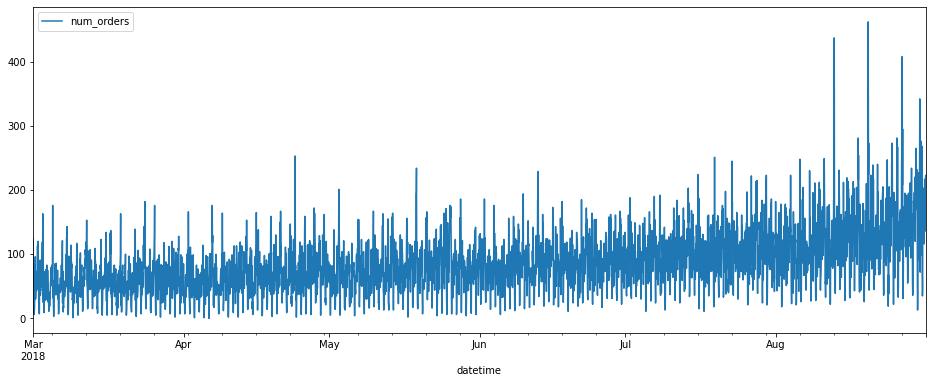

In [ ]:
plt.figure(figsize=(16, 6))
df.resample('1H').sum().plot(ax=plt.gca())

На таком графике ничего не понять, просемплируем данные до дня

<AxesSubplot:xlabel='datetime'>

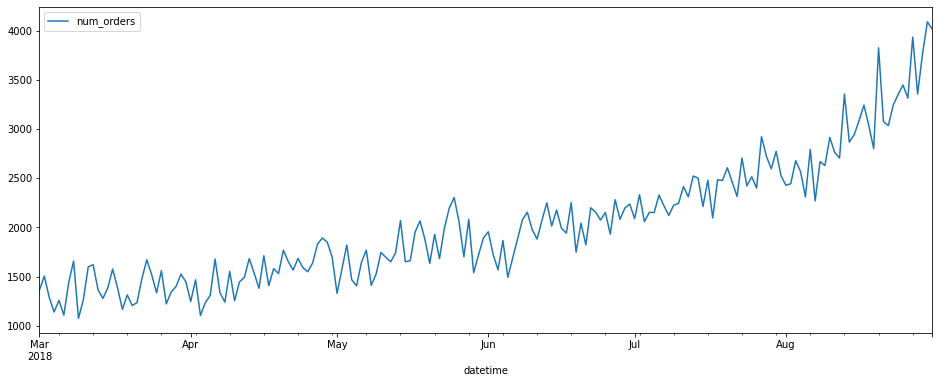

In [ ]:
plt.figure(figsize=(16, 6))
df.resample('1D').sum().plot(ax=plt.gca())

Распределение и среднее значение со временем у временного ряда меняется, поэтому мы можем сделать вывод, что ряд не стационарный.
Можно ещё заметить, что летом/в начале осени количество заказов увеличивается. Возможно это зависит от того, что лето, особенно август, — сезон отпусков и такси берут чтобы доехать, например, до аэропорта или вокзала.

Разложим данные на тренд, сезонность и остаток.

<AxesSubplot:xlabel='datetime'>

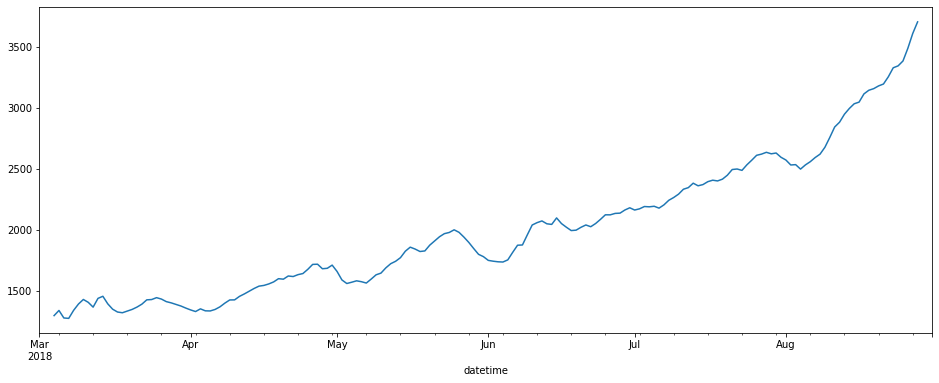

In [ ]:
decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(16, 6))
decomposed.trend.plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

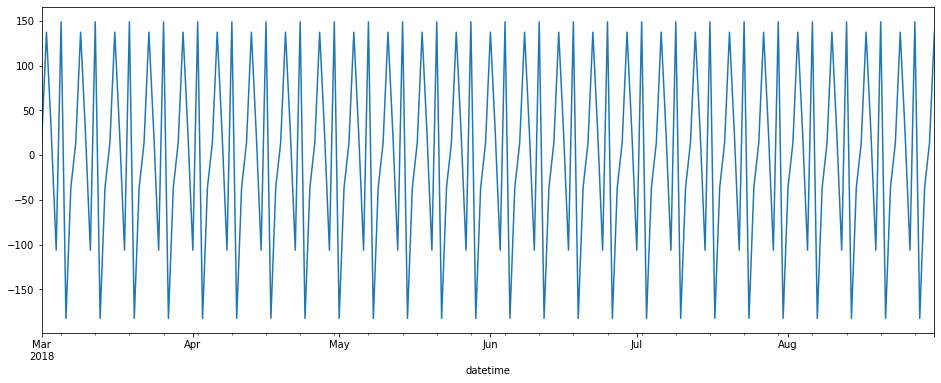

In [ ]:
plt.figure(figsize=(16, 6))
decomposed.seasonal.plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

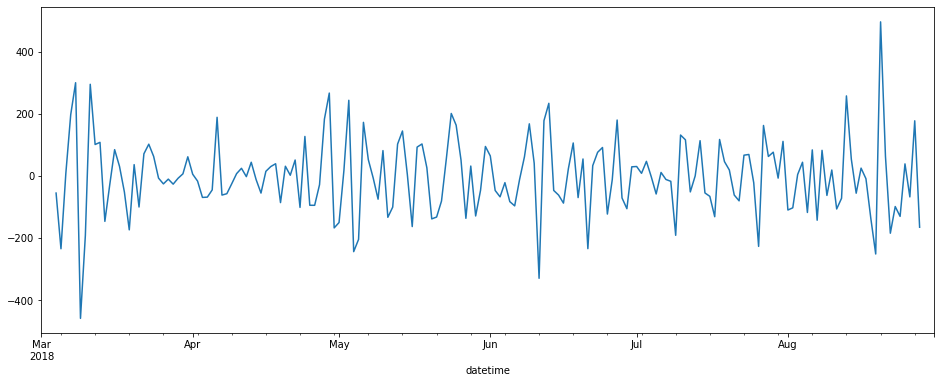

In [ ]:
plt.figure(figsize=(16, 6))
decomposed.resid.plot(ax=plt.gca())

Тренд — увеличение заказов летом
У сезонности такой график, потому что мы взяли небольшой интервал значений. Посмотрим на сезонность за 2 дня

<AxesSubplot:xlabel='datetime'>

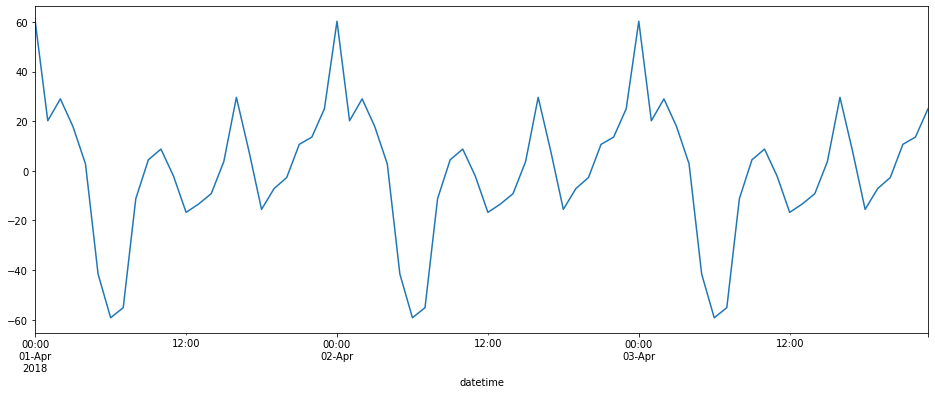

In [ ]:
decomposed = seasonal_decompose(df.resample('1H').sum())

plt.figure(figsize=(16, 6))
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca())

Можем заметить, что наименьшее число заказов приходится на 6-7 утра, а потом стремительно возрастает. Возможно это связано с поездками на работу. Также можно заметить два пика: один к вечеру (возможно, возвращение с работы), а второй поздно ночью (в это время общественный транспорт перестаёт ходить, закрывается метро)

**Вывод**

1. Летом/в начале осени количество заказов увеличивается. Возможно это зависит от того, что лето, особенно август, — сезон отпусков и такси берут чтобы доехать, например, до аэропорта или вокзала. Либо это растёт спрос на такси со временем в принципе.
2. Наименьшее число заказов приходится на раннее утро, а потом стремительно возрастает из-за поездок на работу. Также можно заметить два пика: один к вечеру (возвращение с работы), а второй поздно ночью (в это время общественный транспорт перестаёт ходить, закрывается метро)
3. В данных есть выбросы, поэтому придётся найти дальше скользящее среднее.


<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

## Обучение

Напишем функцию для создания признаков. Она будет создавать:

* Календарные признаки
* Отстающие значения
* Скользящее среднее



In [ ]:
df_new = df

def make_features(data, max_lag, rolling_mean_size):
    data['difference'] = abs(data['num_orders'] - data['num_orders'].shift())
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for i in range(1, max_lag + 1):
        data['lag_' + str(i)] = data['num_orders'].shift(i)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df_new, 10, 10)



In [ ]:
df_new

,num_orders,difference,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,std
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,39.0,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,14.0,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,5.0,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,23.0,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,71.0,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3,35.267391
2018-08-31 20:00:00,154,18.0,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6,35.362252
2018-08-31 21:00:00,159,5.0,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9,34.449480


<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [ ]:
#df_new= df - df.shift(fill_value=df.iloc[0,0])
#df_new = make_features(df, 30, 15,'num_orders')
#df_new.dropna(inplace = True)

<div class="alert alert-block alert-info">
<b>Совет: </b> Таким образом ты изменила задачу и теперь предсказываешь разность, а не количество заказов.
</div>

Разобьем данные на три выборки: обучающую, валидационную и тестовую. Разобьем их в отношении 8:1:1 (10% на тестовую, 10% на валидационную и 80% на обучающую)
Из обучающей удалим пропуски

In [ ]:
df_train, df_valid_1 = train_test_split(df_new, shuffle=False, test_size=0.2, random_state=12345)

df_valid, df_test = train_test_split(df_valid_1, shuffle=False, test_size=0.50, random_state=12345)

df_train = df_train.dropna()

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

Теперь делим данные на целевой остальные признаки

In [ ]:
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid = df_valid['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']

Маштабируем признаки

In [ ]:
#scaler = StandardScaler()
#scaler.fit(features_train)

#features_train = scaler.transform(features_train)
#features_valid = scaler.transform(features_valid)
#features_test = scaler.transform(features_test)

Попробуем обучить модели линейной регрессии, LGBMRegressor и CatBoostRegressor

**Линейная регрессия**

In [ ]:
%%time

lr = LinearRegression().fit(features_train, target_train)
predictions = lr.predict(features_valid)

print('RMSE:','{:.3f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 40.110
CPU times: user 5.69 ms, sys: 15.8 ms, total: 21.5 ms
Wall time: 7.83 ms


**LGBMRegressor**

In [ ]:
def lgbm_f(features_train, target_train, features_valid, target_valid):
    for depth in range(2, 10, 5):
        best_rmse = 48
        best_est = 0
        best_learning_rate = 0
        best_parameters = ''

        for est in range(60, 110, 50):
            for learning_rate in [0.1, 0.3, 0.5]:
                lgbm = LGBMRegressor(max_depth=depth, n_estimators=est, learning_rate=learning_rate, random_state=12345)

                lgbm.fit(features_train, target_train)
                predictions = lgbm.predict(features_valid)

                rmse = mean_squared_error(target_valid, predictions)**0.5

                if best_rmse > rmse:
                    best_learning_rate = learning_rate
                    best_rmse = rmse
                    best_est = est
                    best_parameters = 'Глубина', depth, 'Оценщиков', est

        print('Наилучший результат при', depth, 'глубине, при', est, 'оценщиках:', best_rmse, 'best_learning_rate', best_learning_rate, '\n')

In [ ]:
%%time

lgbm_f(features_train, target_train, features_valid, target_valid)

Наилучший результат при 2 глубине, при 60 оценщиках: 30.83275336955914 best_learning_rate 0.5 

Наилучший результат при 7 глубине, при 60 оценщиках: 29.1594306868302 best_learning_rate 0.1 

CPU times: user 1min 53s, sys: 1.13 s, total: 1min 54s
Wall time: 1min 55s


**CatBoostRegressor**

In [ ]:
def cat_b(features_train, target_train, features_valid, target_valid):

    for depth in range(2, 10, 5):
        best_rmse = 48
        best_iterations = 0
        best_parameters = ''

        for iteration in range(50, 110, 50):
            catboost = CatBoostRegressor(depth=depth, iterations=iteration, random_state=12345)

            catboost.fit(features_train, target_train)
            predictions = catboost.predict(features_valid)

            rmse = mean_squared_error(target_valid, predictions)**0.5


            if best_rmse > rmse:
                best_rmse = rmse
                best_iterations = iteration
                best_parameters = 'Глубина', depth, 'Итераций', iteration

        print('Наилучший результат при', depth, 'глубине, при', best_iterations, 'итерациях:', best_rmse, '\n')

In [ ]:
%%time

cat_b(features_train, target_train, features_valid, target_valid)

Learning rate set to 0.5
0:	learn: 31.6766172	total: 1.02ms	remaining: 50.3ms
1:	learn: 29.5196649	total: 1.98ms	remaining: 47.4ms
2:	learn: 28.0902087	total: 2.8ms	remaining: 43.9ms
3:	learn: 27.2424885	total: 3.58ms	remaining: 41.2ms
4:	learn: 26.7720790	total: 4.36ms	remaining: 39.2ms
5:	learn: 26.1224132	total: 5.33ms	remaining: 39.1ms
6:	learn: 25.1373637	total: 6.13ms	remaining: 37.7ms
7:	learn: 24.7870478	total: 6.89ms	remaining: 36.2ms
8:	learn: 24.6080505	total: 7.82ms	remaining: 35.6ms
9:	learn: 24.4189249	total: 8.63ms	remaining: 34.5ms
10:	learn: 24.1808078	total: 9.39ms	remaining: 33.3ms
11:	learn: 23.9457362	total: 10.1ms	remaining: 31.8ms
12:	learn: 22.9850972	total: 10.8ms	remaining: 30.7ms
13:	learn: 22.1240034	total: 11.6ms	remaining: 29.8ms
14:	learn: 21.6607938	total: 12.4ms	remaining: 29ms
15:	learn: 21.4894240	total: 13.1ms	remaining: 27.9ms
16:	learn: 21.3875201	total: 13.8ms	remaining: 26.8ms
17:	learn: 20.9777474	total: 14.6ms	remaining: 25.9ms
18:	learn: 20.88

28:	learn: 12.4898744	total: 193ms	remaining: 139ms
29:	learn: 12.4082650	total: 197ms	remaining: 131ms
30:	learn: 12.3853837	total: 202ms	remaining: 124ms
31:	learn: 12.3702846	total: 207ms	remaining: 116ms
32:	learn: 12.1869803	total: 211ms	remaining: 109ms
33:	learn: 12.0568172	total: 217ms	remaining: 102ms
34:	learn: 11.7795356	total: 223ms	remaining: 95.7ms
35:	learn: 11.6310862	total: 230ms	remaining: 89.5ms
36:	learn: 11.5171492	total: 237ms	remaining: 83.3ms
37:	learn: 11.3303344	total: 243ms	remaining: 76.7ms
38:	learn: 11.3243896	total: 248ms	remaining: 69.8ms
39:	learn: 11.2032048	total: 253ms	remaining: 63.1ms
40:	learn: 11.1182212	total: 257ms	remaining: 56.5ms
41:	learn: 11.0018779	total: 262ms	remaining: 50ms
42:	learn: 10.9368795	total: 272ms	remaining: 44.2ms
43:	learn: 10.9302088	total: 276ms	remaining: 37.7ms
44:	learn: 10.9163540	total: 282ms	remaining: 31.3ms
45:	learn: 10.7736476	total: 287ms	remaining: 24.9ms
46:	learn: 10.6560924	total: 292ms	remaining: 18.6ms
4

Из 3 обученных моделях на валидационной выборке самой качественной оказалась модель CatBoostRegressor(RMSE: 30.61)

<div class="alert alert-block alert-info">
<b>Совет: </b> Можно было использовать кросс-валидацию и вообще не выделять валидационный набор. При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

## Тестирование

**Линейная регрессия**

In [ ]:
%%time

lr = LinearRegression()
lr.fit(features_train, target_train)
predictions = lr.predict(features_test)

print('RMSE:','{:.3f}'.format(mean_squared_error(target_test, predictions)**0.5))

RMSE: 54.278
CPU times: user 8.73 ms, sys: 12.7 ms, total: 21.4 ms
Wall time: 8.28 ms


**LGBMRegressor**

In [ ]:
%%time

lgbm = LGBMRegressor(max_depth=7, n_estimators=60, learning_rate=0.1, random_state=12345)
lgbm.fit(features_train, target_train)
predictions = lgbm.predict(features_test)

print('RMSE:','{:.3f}'.format(mean_squared_error(target_test, predictions)**0.5))

RMSE: 49.728
CPU times: user 2min 10s, sys: 990 ms, total: 2min 11s
Wall time: 2min 12s


**CatBoostRegressor**

In [ ]:
%%time

catboost = CatBoostRegressor(depth=7, iterations=100, random_state=12345)
catboost.fit(features_train, target_train)
predictions = catboost.predict(features_test)


print('RMSE:','{:.3f}'.format(mean_squared_error(target_test, predictions)**0.5))

Learning rate set to 0.324767
0:	learn: 31.0002468	total: 6.43ms	remaining: 636ms
1:	learn: 27.1314474	total: 12.8ms	remaining: 625ms
2:	learn: 24.2528161	total: 19ms	remaining: 615ms
3:	learn: 22.5051957	total: 26.7ms	remaining: 641ms
4:	learn: 21.0453562	total: 34.6ms	remaining: 658ms
5:	learn: 20.0716354	total: 40.1ms	remaining: 628ms
6:	learn: 19.1126394	total: 46.2ms	remaining: 614ms
7:	learn: 18.6723539	total: 51.7ms	remaining: 595ms
8:	learn: 18.1786704	total: 57.3ms	remaining: 579ms
9:	learn: 17.7385203	total: 63.5ms	remaining: 572ms
10:	learn: 17.5086315	total: 69.1ms	remaining: 559ms
11:	learn: 17.1049468	total: 74.7ms	remaining: 548ms
12:	learn: 16.8362234	total: 80.7ms	remaining: 540ms
13:	learn: 16.5568803	total: 85.5ms	remaining: 525ms
14:	learn: 16.4062554	total: 90.5ms	remaining: 513ms
15:	learn: 16.2172911	total: 95.3ms	remaining: 500ms
16:	learn: 16.1209757	total: 100ms	remaining: 488ms
17:	learn: 15.8942328	total: 105ms	remaining: 478ms
18:	learn: 15.7504351	total: 1

<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

**Вывод**

    На тестовой выборке модель CatBoostRegressor оказалась самой качественной, она единственная получила значение метрики равное 48, остальные модели показалаи метрику хуже. А также она оказалась самой быстрой: на обучение и предсказание вместе у неё уходит менее минуты. LGBMRegressor по времени отработки оказалась самой медленной, а линейная регрессия самой некачественное (RMSE: 54.2)